# Parameters
in this cell the used variables can be changed 

height and width correspond to the dimensions of the Workspace, in which the Topology Optimisation is going to be performed

log_dir is the direction where the current best Model will be saved to during training

ts is the amount of timesteps the model will be trained for




In [9]:
import os
import time

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import autograd.numpy as anp
import scipy

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor


In [10]:
# Here are the parameter for the Optimization

# DESIGN SPACE PARAMETERS

height = 5                             # The height of the design space
width = 10                              # The width of the design space                   
number_of_nodes = height * width        # The number of nodes in the design space
bound_nodes_list = [(0, 0), (0, -1)]    # A list containing the coordinates of 
                                        # the bounded nodes


# PHYSICAL PARAMETERS FOR THE FEM ANALYSIS

filter_width = 1
penal = 3.0
young_min = 1e-9
young = 1
poisson = 0.3
density = 1e-4
constraint_thresh = 0.3


# TECHNICAL PARAMETERS FOR THE REINFORCEMENT LEARNING

number_subprocesses = 8     # The number of Threads to be used during the 
                            # learning process

log_dir = "log/"            # The directory of where to save the best model

ts = 5e6                    # The number of timesteps to be used during the 
                            # learning process



# This is for the used FEM analysis taken from the Gigala repository
# it saves the boundary nodes in a 3D array where the first two dimensions are 
# the coordinates of the node and the third dimension is the direction of the normal
normals = np.zeros((height + 1, width + 1, 2))
x = 0
y = 1
for coords in bound_nodes_list:
    normals[coords[x], coords[y], x] = 1
    normals[coords[x], coords[y], y] = 1




forces = np.zeros((height + 1, width + 1, 2))
forces[-1, -1, y] = -1
forces = forces.ravel()



fixdofs = np.flatnonzero(normals.ravel())
alldofs = np.arange(2 * (normals.shape[0]) * (normals.shape[1]))
freedofs = np.sort(list(set(alldofs) - set(fixdofs)))





path_calculix = "E:/Bachelorarbeit/CalculiX/bConverged/CalculiX/ccx"





In [11]:
def objective(x, volume_contraint=False, use_filter=True):
    """"Objective function for the topology optimization problem.
    Parameters
    ----------
    x : numpy.ndarray
        The design space.
    volume_contraint : bool, optional
        Whether to use the volume constraint.
    use_filter : bool, optional
        Whether to use the filter.
    Returns
    -------
    float
        The compliance of the design space.
    """
    kwargs = dict(penal=penal, e_min=young_min, e_0=young)
    x_phys = physical_density(x, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(young, poisson)  # stiffness matrix
    u      = displace(x_phys, ke, forces, freedofs, fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c


def get_compliance(state):
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state))
    value = objective_fn(state)
    return value

In [12]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()

    return scipy.sparse.linalg.splu(a).solve



# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp


def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)


def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])


def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)


    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]






def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x,volume_contraint=False, use_filter=True):
    x = 1 * x.reshape(height, width)  # reshape from 1D to 2D
    return gaussian_filter(x, filter_width) if use_filter else x  # maybe filter

def mean_density(x, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, volume_contraint, use_filter))

# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')






def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm


In [13]:
def rewardFunction_old(state):
    # This is the Reward Function designed by Gigala
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state))
    value = objective_fn(state)
    return ((1/value)**0.5) *10

def rewardFunction_1(matrix):
    # This a "naive" Reward Function designed by me
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state))
    value = objective_fn(matrix)
    reward = 20 / (np.sqrt(value)) / (constraintFunction(matrix))
    return round(reward, 5)

def rewardFunction_2(matrix, initial_compliance):
    # this is the Reward Function by Nathan Brown modified to fit the different
    # design space and different values used
    comp_frac = ((initial_compliance/get_compliance(matrix)))**2
    removed_node_frac = (get_removed_cells(matrix) / number_of_nodes)**2
    return comp_frac + removed_node_frac

def get_filled_cells(matrix):
    return sum(cell == 1 for row in matrix for cell in row)

def get_removed_cells(matrix):
    return sum(cell == density for row in matrix for cell in row)

def is_continuous(matrix, bound_nodes):
    """This function is used to check if the design space is continuous,
    it uses a depth first search algorithm to check if all the filled cells are
    connected to a specified start point (here the first bound node)
    
    Parameters
    ----------
    matrix : numpy.ndarray
        The design space.
    bound_nodes : numpy.ndarray
        The matrix containing the bound nodes.
    
    Returns
    -------
    bool
        True if the design space is continuous, False otherwise.
    """
    try:
        start = tuple(np.argwhere(bound_nodes == 1)[0]) if np.any(bound_nodes == 1) else None
        end = tuple(np.argwhere(forces == 1)[0]) if np.any(forces == 1) else None
    except ValueError:
        print("there are no bound Nodes given in the bound_nodes matrix")
        return False
    filled_cells = get_filled_cells(matrix)
    visited = dfs(matrix, start, end)
    return len(visited) == filled_cells
 

def dfs(matrix, start, end):
    """This function is the depth first search algorithm that is used to check 
    if all the filled cells in the design space are connected to a specified 
    start point.

    Parameters
    ----------
    matrix : numpy.ndarray
        The design space.
    start : tuple
        The coordinates of the start point.
    end : tuple
        The coordinates of the end point.

    Returns
    -------
    set
        The set containing the visited nodes."""
    rows, cols = len(matrix), len(matrix[0]) 
    visited = set() # Set to keep track of visited nodes    
    stack = [start] # Start the stack with the start node
    if not stack:  # Check if the stack is empty
        raise RuntimeError("The stack is empty")
    while stack:
        (row, col) = stack.pop()    # pop the last coordinates from the stack
        if (row, col) == end:       # Check if the end point is reached
            visited.add((row, col)) # Add the end point to the visited set
            return visited          # Return the visited set
        if (row < 0 or 
            row >= rows or 
            col < 0 or 
            col >= cols or 
            (row, col) in visited or 
            matrix[row][col] == density): 
            #checking for discarding conditions
            continue
        visited.add((row, col))     # Add the current node to the visited set
        stack.extend([(row-1, col), (row+1, col), (row, col-1), (row, col+1),
                      (row-1, col-1), (row-1, col+1), (row+1, col-1), (row+1, col+1)])
        # Add the neighbours of the current node to the stack
    return visited


def constraintFunction(state):
    reshape = lambda state: state.reshape(height, width)
    constraint = lambda params: mean_density(reshape(params)) 
    const = constraint(state)
    return const

# Thoughts on training rewards
## Positive rewards
- While an Episode has not yet ended, we will, continuously, with each step that gets made, add to the Reward Variable.
- The Reward should mainly come from a Function, that calculates the physical properties of the Design, and evaluates them while taking into Consideration the "weight" of the design
- For this we have available the Compliance function by Gigala as well as his Constraint Function

## Quitting criteria
All of these should also give a senseful negative reward and end the current Episode

- if the action would result in the Design space no longer being continous
- if the action has already been executed
- if the action would remove a bounded or loaded node



## Reward Function used by Nathan Brown: 
$r_{ts}=\left(\frac{c_0}{c_t}\right)^{2}+\left(\frac{\alpha_t}{N^{2}}\right)^2$
- $c_s$ is the inital strain Energy of a wholey filled in Design Space,
- $c_t$ is the strain Energy of the Design Space at the current Timestep,
- $\alpha_t$ is the number of removed elements at this timestep
- $N^{2}$ is the Dimension of the quadratic Design Space used by Nathan Brown

We can try to modify it for our Optimization in the following way:<br>
$r_{ts}=\left(\frac{2*comp_0}{2*comp_t}\right)^{2}+\left(\frac{\alpha_t}{l*w}\right)^2=\left(\frac{comp_0}{copm_t}\right)^{2}+\left(\frac{\alpha_t}{l*w}\right)^2$ because: $strain  energy = \frac{1}{2}*compliance$
- $comp_0$ is the inital compliance of a wholey filled in Design Space,
- $c_t$ is the compliance of the Design Space at the current Timestep,
- $\alpha_t$ is the number of removed elements at this timestep
- $l$ is the length of our Design Space
- $w$ is the width of our Design Space
<br>
### The Relation between Strain Energy and Compliance can be dereived as follows
- compliance is defined as:
$$C=F^Tu$$
where $F$ is the Force Vector and $u$ is the Displacement Vector
- Strain Energy is defined as:
$$U=\frac{1}{2}u^TKu$$
where $K$ represents the stiffnes matrix
- using the equation of the stiffnes matrix $Ku=F$, displacement can be expressed as:
$$u=K^{-1}F$$
- now we substitute $u=K^{-1}F$ into our Compliance Function:
$$C=F^Tu=F^TK^{-1}F$$
- now we do the same for our strain energy equation
$$U=\frac{1}{2}u^TKu=\frac{1}{2}\left(K^{-1}F\right)^TK\left(K^{-1}F\right)=\frac{1}{2}F^TK^{-1}F$$
- we now see, that we can substitue in the compliance function as Follows
$$\frac{1}{2}F^TK^{-1}F=\frac{1}{2}C$$
- Thus we have the relation between the strain Energy and compliance, and can
modify the function used in NathanBrown's Topology Optimization for our Code




Different Matrices with their respective Reward Functions and Compliance Values:


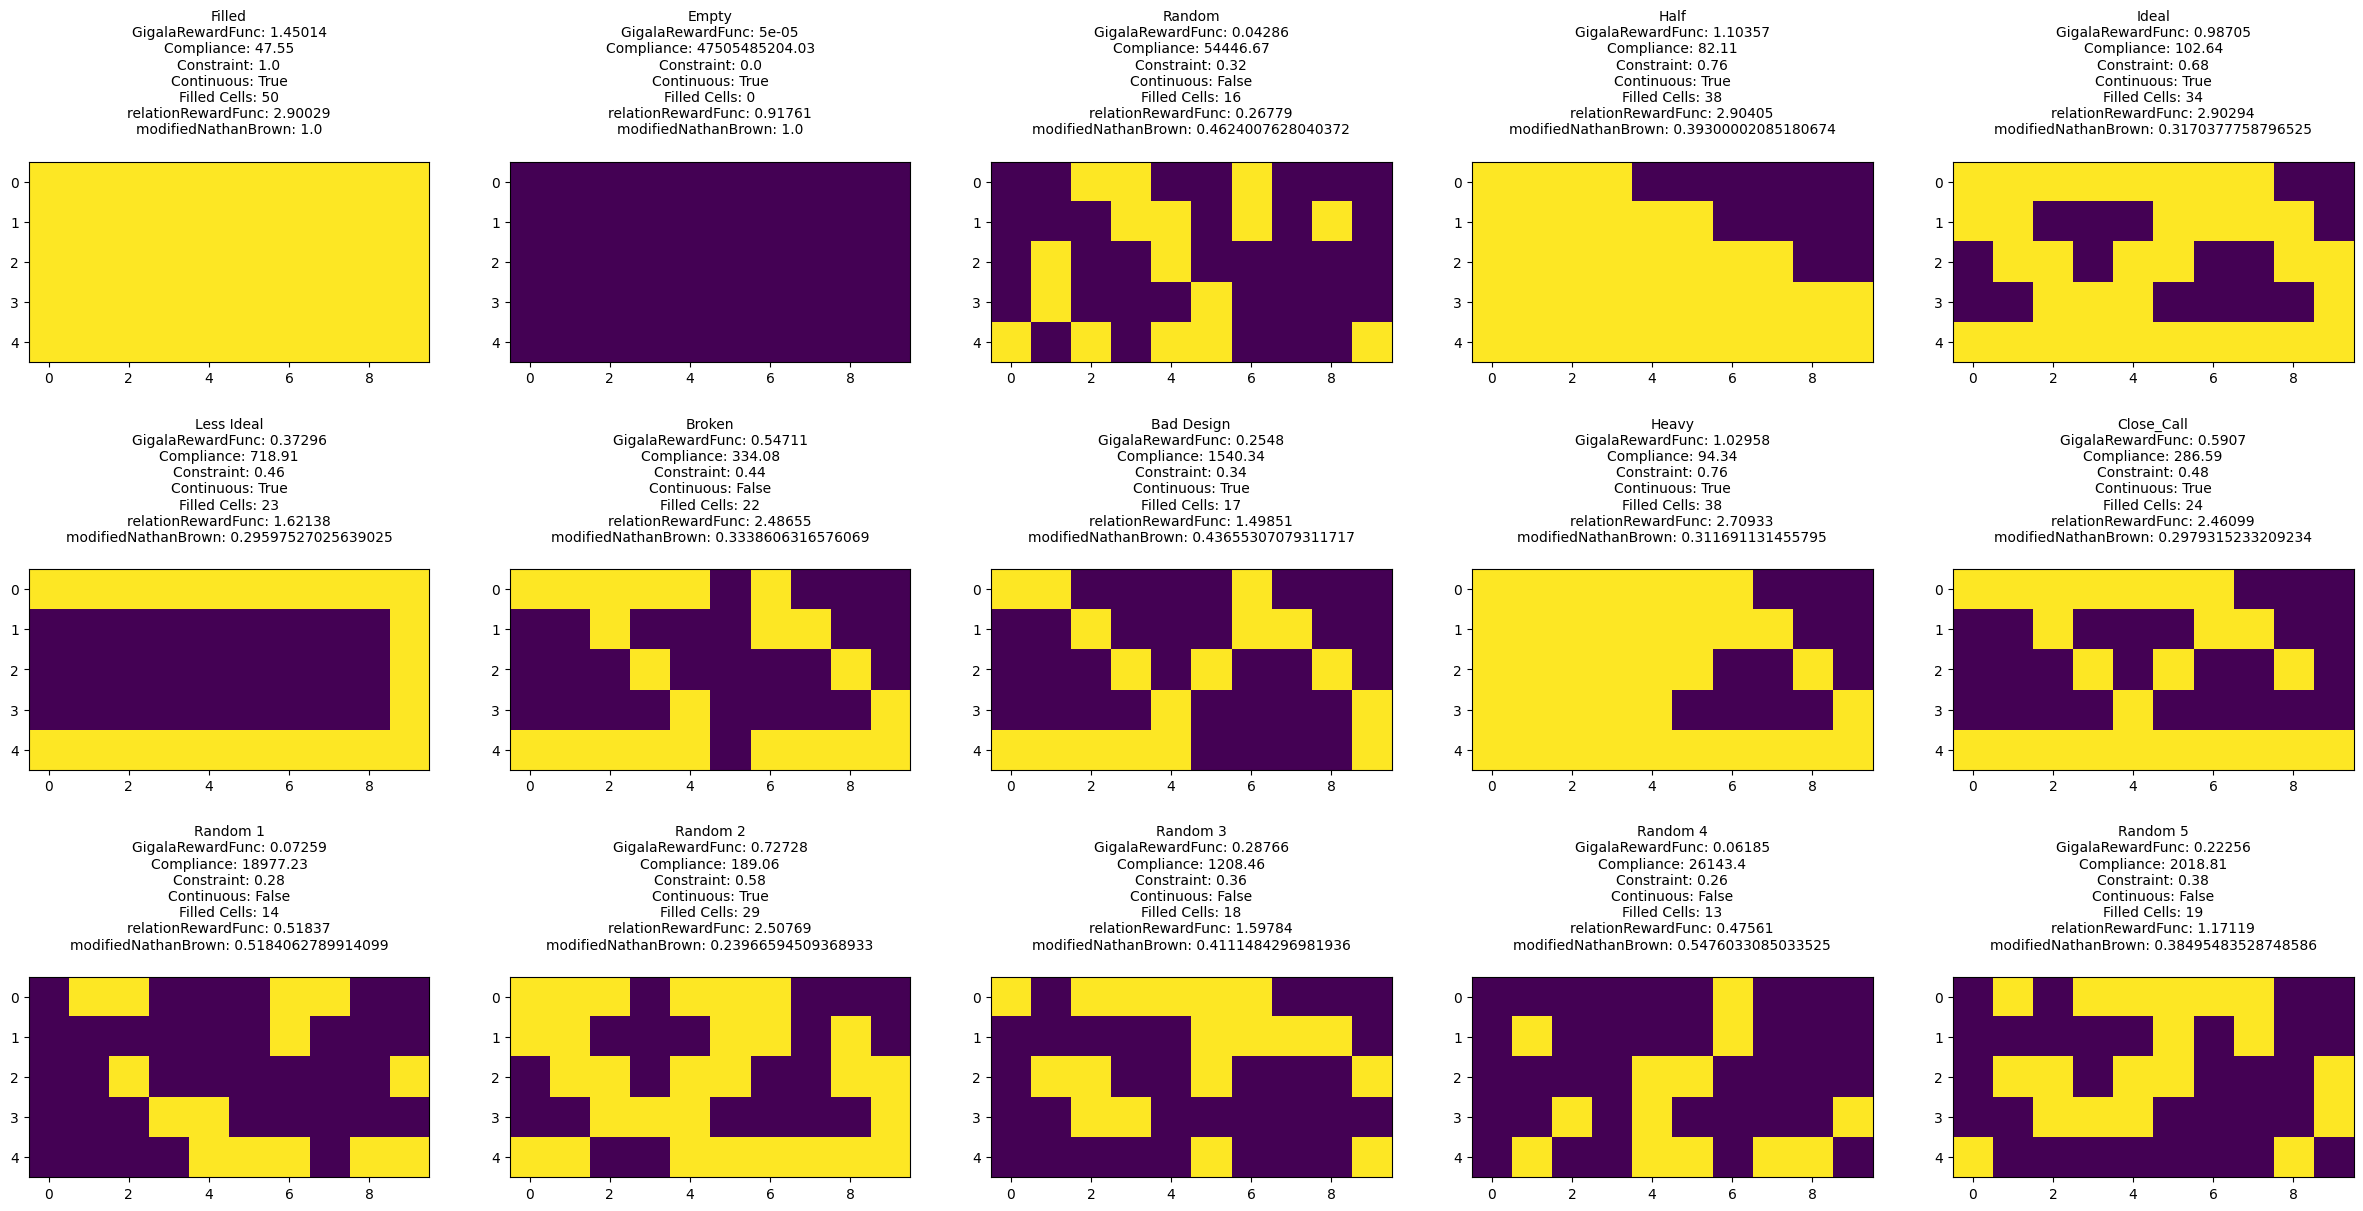

Showcasing a Design Process with the Reward Functions and Compliance Values:


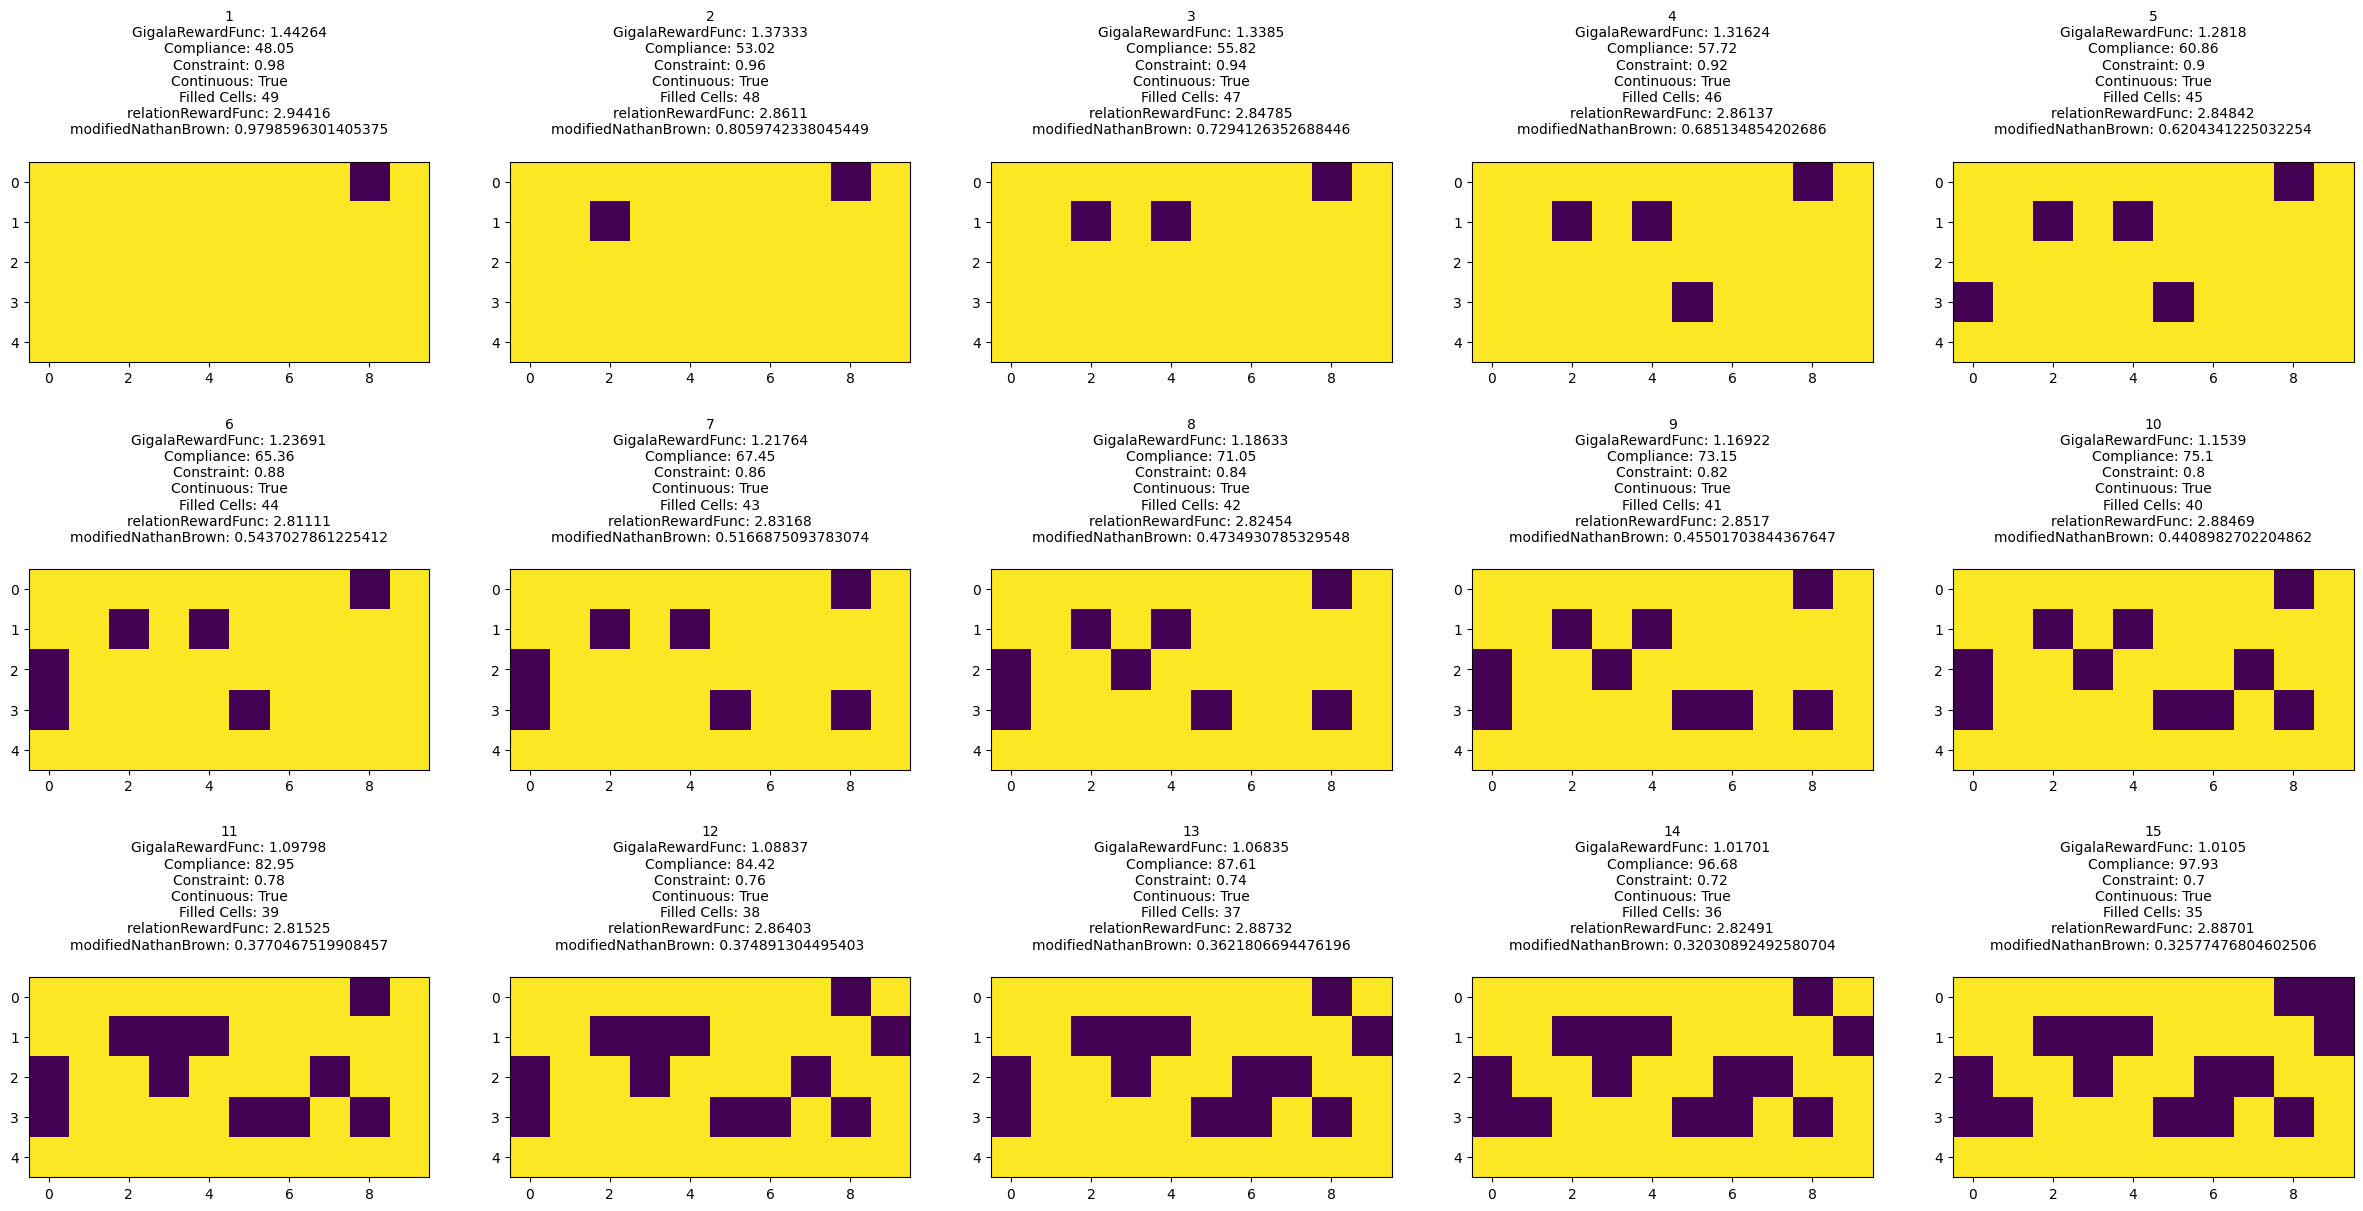

In [21]:
#TESTING

def render_all(states):
    """This function is used to render the different design spaces with their
    respective reward functions and compliance values.

    Parameters
    ----------
    states : list
        The list containing the different design spaces.

    Returns
    -------
        None
    """
    num_rows = 3
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 15))
    for i, state in enumerate(states):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].imshow(states[i]["matrix"].reshape(height, width), vmin=density, vmax=1)
        title = (state["Name"]
        + "\nGigalaRewardFunc: " + str(round(state["rewardfunc"], 5))  
        + "\nCompliance: " + str(round(state["Compliance"], 2))
        + "\nConstraint: " + str(round(state["constraint"], 3)) 
        + "\nContinuous: " + str(state["continuous"])
        + "\nFilled Cells: " + str(state["filled_cells"])
        + "\nrelationRewardFunc: " + str(state["reward1"])
        + "\nmodifiedNathanBrown: " + str(state["reward2"]))
        axs[row, col].set_title(title, fontsize=10, pad=20)
    plt.show()


def flip_random_elements(matrix):
    matrix_copy = np.copy(matrix)
    rows, cols = matrix_copy.shape
    num_elements_to_flip = np.random.randint(1, rows*cols)
    row_indices = np.random.randint(0, rows, num_elements_to_flip)
    col_indices = np.random.randint(0, cols, num_elements_to_flip)
    for row, col in zip(row_indices, col_indices):
        matrix_copy[row, col] = 1 if matrix_copy[row, col] == density else density
    return matrix_copy

def turn_random_density_to_one(matrix):
    matrix_copy = np.copy(matrix)
    zero_indices = np.argwhere(matrix_copy == density)
    if zero_indices.size == density:
        return matrix_copy
    random_index = zero_indices[np.random.choice(zero_indices.shape[0])]
    matrix_copy[tuple(random_index)] = 1
    return matrix_copy

def zero_to_densitiy(matrix):
    return np.where(matrix == 0, density, matrix)


# create the initial compliance of a completely filled in design space
initial_compliance = get_compliance(np.ones((height, width)))

# Here we initialize the bound node matrix as well as the states and matrices list
bound_nodes = np.zeros((height, width))
for coord in bound_nodes_list:
        bound_nodes[coord] = 1
states = []
matrices = []

# Here we create the different matrices that we want to showcase
# First a fully filled in Matrix
filled_matrix = np.ones((height, width))
matrices.append(filled_matrix)

# An Empty Matrix
empty_matrix = zero_to_densitiy(np.zeros((height, width)))
matrices.append(zero_to_densitiy(empty_matrix))

# A randomly generated Matrix
random_matrix = np.random.choice([density, 1], (height, width))
matrices.append(random_matrix)

# A half filled in Matrix
half_matrix = [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(half_matrix))

# A Matrix which represents a more or less ideal design
ideal_matrix = [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
                [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
                [0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(ideal_matrix))

# A Matrix which represents a worse design
less_ideal_matrix = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(less_ideal_matrix))

# A copy of the ideal design, with a break in it
broken_matrix = [[1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(broken_matrix))

# A Matrix which represents a very elastic design
bad_design = [[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
              [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]]
matrices.append(zero_to_densitiy(bad_design))

# A matrix which represents a stiff but heavy design
heavy_matrix = [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
                [1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(heavy_matrix))

# A copy of the ideal matrix with a crucial node missing
close_call_matrix = zero_to_densitiy([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                                      [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
                                      [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
matrices.append(zero_to_densitiy(close_call_matrix))

# A few copies of the ideal matrix with a few random elements flipped
random_matrix_1 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_1)
random_matrix_2 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_2)
random_matrix_3 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_3)
random_matrix_4 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_4)
random_matrix_5 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_5)

# for some reason the zero_to_density funcion only works if doing it twice
matrices = list(map(lambda matrix: zero_to_densitiy(matrix), matrices))

# Here we create a list of names for the different matrices
matrix_names = ["Filled", "Empty", "Random", "Half", "Ideal", "Less Ideal", "Broken", "Bad Design", "Heavy", "Close_Call", "Random 1", "Random 2", "Random 3", "Random 4", "Random 5"]
# init the dictionary
matrix_dict = {}


# fill the dictionary with the matrices and their respective names
# calculate the reward functions and compliance values
# and add them to the states list
for name, matrix in zip(matrix_names, matrices):
    state = {
        "matrix" : matrix, 
        "Name" : name, 
        "rewardfunc" : rewardFunction_old(matrix), 
        "constraint" : constraintFunction(matrix),
        "Compliance" : objective(matrix), 
        "continuous" : is_continuous(matrix, bound_nodes),
        "filled_cells" : get_filled_cells(matrix),
        "reward1" : rewardFunction_1(matrix),
        "reward2" : rewardFunction_2(matrix, initial_compliance)
    }
    states.append(state)
print("Different Matrices with their respective Reward Functions and Compliance Values:")
render_all(states)

# reset the different lists for the second test run
states.clear()
matrices.clear()
matrix_names.clear()
matrix_dict.clear()

# again for some reason zero_to_density only works if done twice
ideal_matrix = zero_to_densitiy(ideal_matrix)
matrices.append(zero_to_densitiy(ideal_matrix))

# create a copy of the last matrix in the list, turn a random voided element
# into a filled one and add it to the matrices list.
# continue doing so to simulate 15 steps of a design process to analyse the
# reward functions and compliance values
for i in range(0, 15):
    temp = turn_random_density_to_one(matrices[i])
    temp = zero_to_densitiy(temp)
    matrices.append(temp)

# reverse the list of matrices to get the correct order
matrices.reverse()
matrix_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"]

for name, matrix in zip(matrix_names, matrices):
    state = {
        "matrix" : matrix, 
        "Name" : name, 
        "rewardfunc" : rewardFunction_old(matrix), 
        "constraint" : constraintFunction(matrix),
        "Compliance" : objective(matrix), 
        "continuous" : is_continuous(matrix, bound_nodes),
        "filled_cells" : get_filled_cells(matrix),
        "reward1" : rewardFunction_1(matrix),
        "reward2" : rewardFunction_2(matrix, initial_compliance)
    }
    states.append(state)
print("Showcasing a Design Process with the Reward Functions and Compliance Values:")
render_all(states)

# Explaining the different Values

- oldRewardfunction returns $\sqrt{\left(\frac{1}{compliance}\right)}$ with the compliance representing the elasticity of the design this is the original reward function by gigala
- Compliance represents the current Elasticity Factor of the Design. It is the Inverse of the Stiffness
- Constraint is the normalized volume of the design
- Continuous is a Boolean representing if the Bounded Node is connected to the Node which has a force applied to it
- Filled Cells is the Number of cells, which are currently filled in
- Reward1 is the value of the naive rewardFunction written by me
- Reward2 is the value of the modified reward function used by Nathan Brown

# Planning the Enviroment
## Variables
- __design_space:__
    - This will be a Matrix consisting of filled and voided Elements, represented by ones and the density constant.
    - It will have the Dimensions set in the Parameters Cell
    - It should be initialized to be completely filled
- __bound_nodes:__
    - This will be a Matrix consisting of ones and zeros, representing which Elements are bounded
    - It will be of the same Dimensions as design_space
    - It will get the coordinates of bounded nodes from the bound_node_list in the Parameters Cell
- __force_nodes:__
    - This will be a Matrix consisting of ones and zeros, representing which Elements have a force applied to them
    - It will be of the same Dimensions as design_space and bound_nodes
    - It will get the coordinates of loaded nodes form the force_node_list in the Parameters Cell
- __action_space__:
    - This Variable is required by the gym Module for any Reinforcement Learning Enviroment
    - It will tell training agent how many actions it can take.
    - In our case it is going the be set as many discrete actions, as there are Elements in the Design Space
- __actions_to_coordinates__:
    - This will be a Dictionary with one key. The key being an Integer and the associated Value being a Tuple
    - The Number will be incrementing from zero to number_of_nodes, which represents the amount of Elements in the design space
    - This Number will be connected to a Tuple, representing the coordinates of an Element in the Design space
    - This will make it poosible for the reinforcment learning agent to choose actions as simple Integers, which then will be equated to an Element in the Design Space
    - In this way, choosing a number as action can be used to remove an Element from the Design Space
    - Example: 0: (0,0), 1: (0, 1), 2: (1, 0), 3: (1, 1), ..... number_of_nodes: (height, width)
- __performed_actions:__
    - This will simply be a list that keeps track of which actions have previously been performed in this Episode
    - It will be used as an Ending criteria, as well as in the rewarding of actions
- __reward:__
    - This Variable will simply keep track of the current reward of the Episode
- __step_count__
    - This Varuable will be used to count the number of steps that have taken place in this Episode
    - might be used fot ending criteria or rewarding

## Functions
- __init(self)__
    - This Function will initialize the Enviroment, so it will call the super constructor
    - The Variables we should initialize here are:
        - __design_space__ as matrix of dimensions __height__ and __width__, where every Element equals 1 
        - __bound_nodes__ as matrix filled with ones and zeros according to __bound_nodes_list__
        - __force_nodes__ as matrix filled with ones and zeros according to __force_nodes_list__
        - __action_space__ as gym.spaces.Discrete Object with length __number_of_nodes__
        - __observation_space__ as gym.spaces.Box Object with Dimensions __height__ and __width__
        - __reward__ with value 0
        - __step_count__ with value 0
    - also the __actions_to_coordinates__ dictionary should be initialized 
    - lastly it should call the __reset(self)__ function to reset as well as initialize all the Values, that get set there.

- __reset(self)
    - This function will reset Variables, that need to be a certain Value at the beginning of an Episode to their correct inital Value
    -



In [15]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self):
        
        # The constructor of the environment
        super().__init__()

        # the design space is what contains the information about which cells
        # are filled with material and which are not
        self.design_space = anp.ones((height, width))

        # the bound nodes matrix contains the information about which cells
        # are fixed in place and which are not
        self.bound_nodes = np.zeros((height, width))
        for coord in bound_nodes_list:
            self.bound_nodes[coord] = 1
        
        # the force nodes matrix contains the information about which cells
        # have a force applied on them and which do not
        self.force_nodes = np.zeros((height, width))
        
        
        # Each Node in the Matrix is a performable action
        self.action_space = gym.spaces.Discrete(number_of_nodes)
        self.observation_space = gym.spaces.Box(low=0, 
                                                high=1, 
                                                shape=(height, width), 
                                                dtype=np.float64)

        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the optimization
        # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes = (height,width)
        self._actions_to_coordinates = {}  
        k=0
        for i in range(height):
            for j in range(width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1


        # initialize both the reward and the step count
        self.reward = 0
        self.step_count = 0

        self.reset()

    def step(self, action):
   
        # actions are the coordinates of the node that is going to be changed
        # action is a number between 0 and number_of_nodes

        self.step_count += 1
        terminated = False

        # Check if the selected Action has already been performed on this state
        if action in self.performed_actions:
             self.reward= -100
             return self.design_space, self.reward, terminated, False, self.getInfo()

        #check if the selected Node is either bound or force node
        print(self._actions_to_coordinates[action])
        if self.bound_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        if self.force_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        #Check if the selected Node is already removed
        if self.design_space[self._actions_to_coordinates[action]] < 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()

        if not is_continuous(self.design_space, self.bound_nodes):
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        # exectute an action and get the Reward
        self.remove_node(action)

        self.reward += rewardFunction(self.design_space)
        self.constraint = constraintFunction(self.design_space)
        
        # reward for removing nodes
        # calculated by comparing the number of nodes in the design space with the number of nodes that are not zero
        # basically: the less nodes that are one the better
        # (multiplying the non_zero elements is to scale the reward)
        self.reward += (np.size(self.design_space)-np.count_nonzero(self.design_space)) * np.size(self.design_space)
        if is_continuous(self.design_space, self.bound_nodes):
            self.reward += 1000
        
         
        if self.constraint < constraint_thresh:
            self.reward -= 1
            terminated = True
        
        # If after having gone through as many steps as there are nodes
        # the design isn't continuos the agent is punished and the episode ended
        if self.step_count > number_of_nodes:
            if not is_continuous(self.design_space, self.bound_nodes):
                self.reward = -1000
                terminated = True
        
        
       
        # add the current action to the list of performed actions
        self.performed_actions.append(action)



        return self.design_space, self.reward, terminated, False, self.getInfo()
    

    def remove_node(self, action):
        self.design_space[self._actions_to_coordinates[action]] = density
    
    def reset(self, seed=None):
        # Reset the environment
        # This function returns the initial state of the environment
        # The initial state should be a 2D array of size (height, width)
        #
        self.performed_actions = []

        super().reset(seed=seed)
        self.design_space = anp.ones((height, width))
        
        self.constraint = constraintFunction(self.design_space)
        self.reward = 0
        self.step_count = 0

        # initialize the bound and force nodes
        self.bound_nodes = np.zeros((height, width))
        self.force_nodes = np.zeros((height, width))
        
        # We chose arbitrary but senseful Values here 
        # So this Enviroment wil train a Model, only fit to solve the problem
        # that gets specified here
        self.bound_nodes[0, 0] = 1
        self.bound_nodes[0, -1] = 1
        self.force_nodes[-1,-1] = 1

        return self.design_space, self.getInfo()
    

    def render(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        fig, ax = plt.subplots()
        ax.imshow(self.design_space)
        plt.show()
    
    def getInfo(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space}
    
    def debug(self):
        print(self.design_space)

In [16]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            # os.makedirs(self.save_path, exist_ok=True
            return

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                vecenv_render(env)
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [17]:
env = SubprocVecEnv([lambda: TopOptEnv() for _ in range(number_subprocesses)]) #### trying to multiprocess
#env = TopOptEnv()
#check_env(env, warn=True)

# Logs will be saved in log_dir/monitor.csv
env = VecMonitor(env, log_dir)

#env = Monitor(env, log_dir)
#check_env(env, warn=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)






In [18]:
def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("getInfo")
    fig, axs = plt.subplots(1,number_subprocesses)
    fig.set_size_inches(20, 10)
    
    for i in range(number_subprocesses):
        axs[i].imshow(design_spaces[i]["design_space"],vmin=density, vmax=1)
        axs[i].set_title(i+1)
    
    plt.show()    




In [19]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   
print("Elapsed Time = " + str(end-start))

EOFError: 

In [ ]:
#env.close()
env = TopOptEnv()
model_best = PPO.load("log/best_model",env=env)
obs, _ = env.reset()
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    action = action.item()
    print(f"Step {i + 1}")
    # print("Action: ", action)       # added Console Outputs for better understanding  
    obs, rewards, dones, _, info = env.step(action)
    if i%10 == 0:
        env.render()
    # if dones:
    #     print("Goal reached!", "reward=", rewards)
    #     break
    i+=1





In [ ]:
# TODO test and debuo bjective function and all components(displace stiffnes physical density) with predetermined designs
# wth smaller design spaces
# TODO again the same but within the TopOptEnv

# maybe export the topoptenv as python script 
# for debugging
# 
# import into terminal 
#  
# Markdown Notizen für nächste